In [2]:
#load library
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from __future__ import print_function

import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [3]:
#set global Variables/hyperparameters
batchSize = 100
orginalDim =28*28
latentDim = 2
intermediateDim = 256
epochs= 50
epsilonSTD = 1.0

In [4]:
#Sampling function 
def sampling(args: tuple):
    zMean, zLogVar = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0],latentDim),mean=0.,stddev=epsilonSTD)
    return zMean+K.exp(zLogVar/2)*epsilon

In [5]:
#Creating encoder
x = Input(shape=(orginalDim),name="input")
h = Dense(intermediateDim,activation="relu", name="encoding")(x)
#mean of the latent space
zMean= Dense(latentDim,name="mean")(h)
#log variance of the latent space
zLogVar = Dense(latentDim, name="log-variance")(h)

z= Lambda(sampling, output_shape=(latentDim,))((zMean,zLogVar))
encoder = Model(x,[zMean,zLogVar,z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [6]:
#Decoder
inputDecoder = Input(shape=(latentDim,),name="decoder_input")
decoderH = Dense(intermediateDim,activation="relu",name="decoder_h")(inputDecoder)
xDecoded = Dense(orginalDim,activation="sigmoid",name="flat_decoded")(decoderH)
decoder = Model(inputDecoder,xDecoded,name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Create Variational Autoencoder
outputCombined = decoder(encoder(x)[2])
vae = Model(x,outputCombined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [8]:
#loss function
def vaeLoss(x: tf.Tensor, xDecodedMean: tf.Tensor,zLogVar = zLogVar,zMean=zMean,orginalDim=orginalDim):
    xentLoss = orginalDim*metrics.binary_crossentropy(x,xDecodedMean)
    klLoss = -0.5*K.sum(1+zLogVar-K.square(zMean)-K.exp(zLogVar),axis=-1)
    vaeLoss = K.mean(xentLoss+klLoss)
    return vaeLoss

vae.compile(optimizer="rmsprop",loss ="binary_crossentropy")
vae.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [9]:
#Import and split data
(xTrain, yTrain), (xTest,yTest) = mnist.load_data()
xTrain = xTrain.astype("float32")/255.
xTest = xTest.astype("float32")/255.
xTrain = xTrain.reshape((len(xTrain),np.prod(xTrain.shape[1:])))
xTest = xTest.reshape((len(xTest),np.prod(xTest.shape[1:])))

In [10]:
vae.fit(xTrain,xTrain,shuffle = True, epochs=epochs,batch_size=batchSize)

Epoch 1/50
600/600 [==============================] - 7s 9ms/step - loss: 0.2292
Epoch 2/50
600/600 [==============================] - 5s 9ms/step - loss: 0.2051
Epoch 3/50
600/600 [==============================] - 6s 9ms/step - loss: 0.2000
Epoch 4/50
600/600 [==============================] - 8s 14ms/step - loss: 0.1970
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1948
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1931
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1916
Epoch 8/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1904
Epoch 9/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1894
Epoch 10/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1884
Epoch 11/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1875
Epoch 12/50
600/600 [==============================] - 5s 8ms/step - loss: 0.1868
Epoch 13/50
600/600 [===

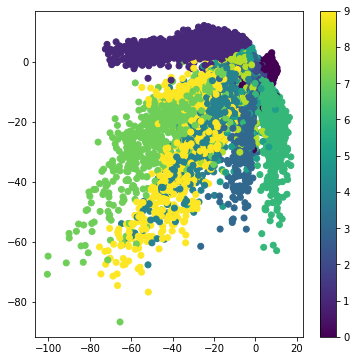

In [16]:
xTestEncode = encoder.predict(xTest,batch_size=batchSize)[0]
plt.figure(figsize=(6,6))
plt.scatter(xTestEncode[:,0],xTestEncode[:,1],c=yTest,cmap="viridis")
plt.colorbar()
plt.show()

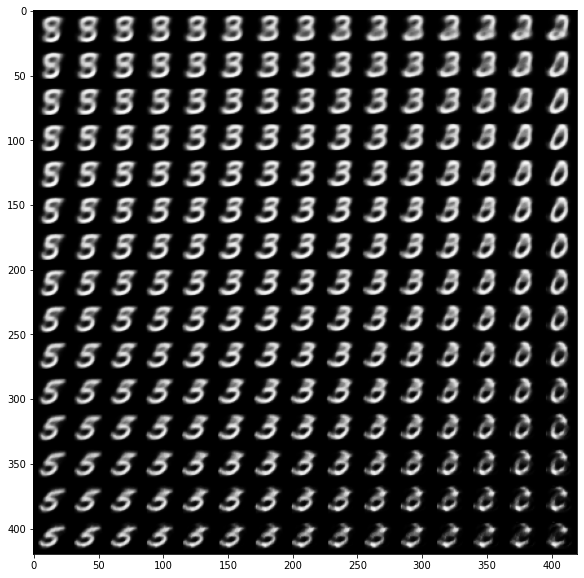

In [19]:
n = 15
digitSize = 28
figure = np.zeros((digitSize*n,digitSize*n))
gridX=norm.ppf(np.linspace(0.05,0.95,n))
gridY=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(gridX):
    for j, xi in enumerate(gridY):
        zSample = np.array([[xi,yi]])
        xDecoded = decoder.predict(zSample)
        digit = xDecoded[0].reshape(digitSize,digitSize)
        figure[i*digitSize:(i+1)*digitSize,j*digitSize:(j+1)*digitSize] = digit
plt.figure(figsize=(10,10))
plt.imshow(figure,cmap="Greys_r")
plt.show()